In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib
%matplotlib inline
mpl.rcParams['figure.dpi'] = 220

/anaconda3/envs/la/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Features information preprocessing

In [2]:
clf = joblib.load('files/model.pkl')
genes = {str(i): gene for i, gene in enumerate(map(str.strip, open('files/common_genes.txt').readlines()))}

In [18]:
ntoclass = {}
cancers = ['ACC', 'BLCA', 'BRCA', 'GBM', 'GBMLGG', 'KIPAN', 'LUAD', 'OV', 'STES', 'HNSC', 'COADREAD', 'COAD', 'LGG', 'KIRC', 'CESC']
clss = open('files/tissues.txt').readlines()
available = set(clf.classes_)

for l in clss:
    cls, n = l.split('–')
    if int(cls) in available:
        ntoclass[int(cls)] = n.strip()
ntoclass.update(dict(zip(range(54, 69), cancers)))

In [19]:
def reduce(df):
    feat = pd.DataFrame()
    for cls in available:
        mean = df[df['class'] == cls].mean()
        feat = feat.append(mean, ignore_index=True)

    feat['class'] = feat['class'].astype('int')
    feat['class'] = feat['class'].apply(lambda cls: ntoclass[cls])
    feat = feat.rename(columns=genes)
    feat = feat.loc[:, ~feat.columns.isin(['Unnamed: 0'])].set_index('class')
    return feat

# Plots

## Sklearn feature importances

/anaconda3/envs/la/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


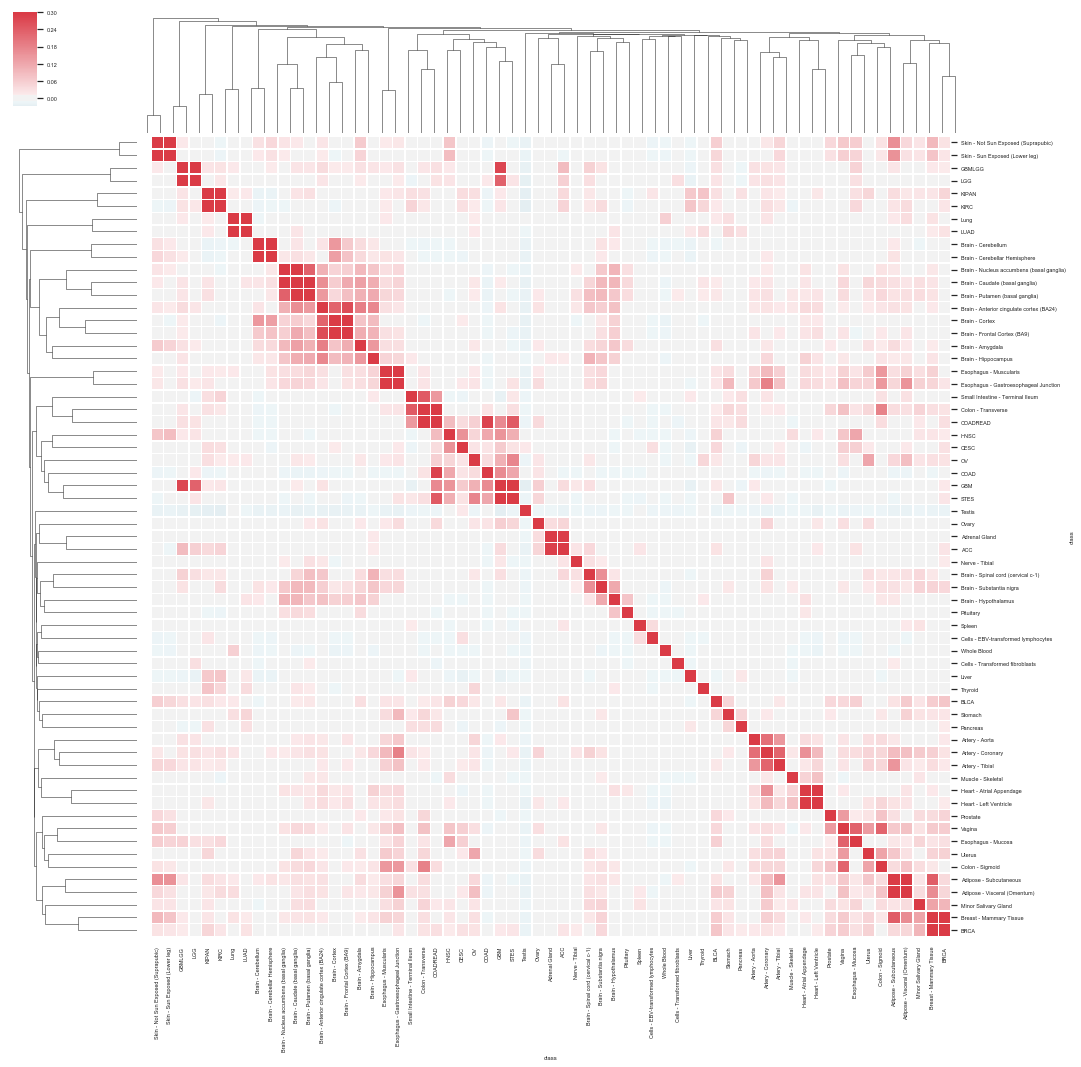

In [20]:
feat = reduce(pd.read_csv('files/features_meta_raw1.csv'))
corr = feat.T.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(font_scale=0.5)
heatmap = sns.clustermap(corr, cmap=cmap, vmax=.3, center=0, square=True,
                         linewidths=.5, cbar_kws={"shrink": .5},
                         xticklabels=True, yticklabels=True, figsize=(17, 17))
plt.tight_layout()
#plt.savefig('heatmap2.png', dpi=170)

In [16]:
def calc_features_statistics(df):
    grt_zero = []
    grt_mean = []
    grt_mean_std = []
    for cls in df.index:
        mean = df.loc[cls].mean()
        std = df.loc[cls].std()
        grt_zero.append((df.loc[cls] > 0).sum())
        grt_mean.append((df.loc[cls] > mean).sum())
        grt_mean_std.append((df.loc[cls] > mean + std).sum())
    return grt_zero, grt_mean, grt_mean_std

In [17]:
def show_bar_plots(y1, y2, y3, y_offset, plot_name):
    fig, axs = plt.subplots(2, figsize=(18, 6))
    ax, ax1 = axs

    ax.bar(0.5 + np.arange(len(feat.index)), y1)
    ax.set_xticks(0.7 + np.arange(len(feat.index)))
    ax.set_xticklabels(feat.index, rotation='vertical', ha="right", fontsize=4)
    ax.set_ylabel('Number of features')
    ax.set_title('Greater than zero')
    t = ax.title
    t.set_position([.5, 1.2])
    for i in np.arange(len(feat.index)):
        ax.text(0.4 + i, y1[i] + y_offset[0], str(y1[i]), rotation='vertical',
                color='#007acc', fontsize=4, fontweight='bold')

    ax1.bar(0.5 + np.arange(len(feat.index)), y2, label='> mean')
    ax1.bar(0.5 + np.arange(len(feat.index)), y3, label='> mean + std')
    ax1.set_xticks(0.7 + np.arange(len(feat.index)))
    ax1.set_xticklabels(feat.index, rotation='vertical', ha="right", fontsize=4)
    ax1.set_ylabel('Number of features')
    ax1.set_title('Greater than mean/mean+std')
    t1 = ax1.title
    t1.set_position([.5, 1.2])
    for i in np.arange(len(feat.index)):
        ax1.text(0.4 + i, y2[i] + y_offset[1], str(y2[i]), rotation='vertical',
                color='#007acc', fontsize=4, fontweight='bold')
    ax1.legend()
    plt.subplots_adjust(hspace=1.5)
    plt.savefig(plot_name, dpi=300)
    plt.show()

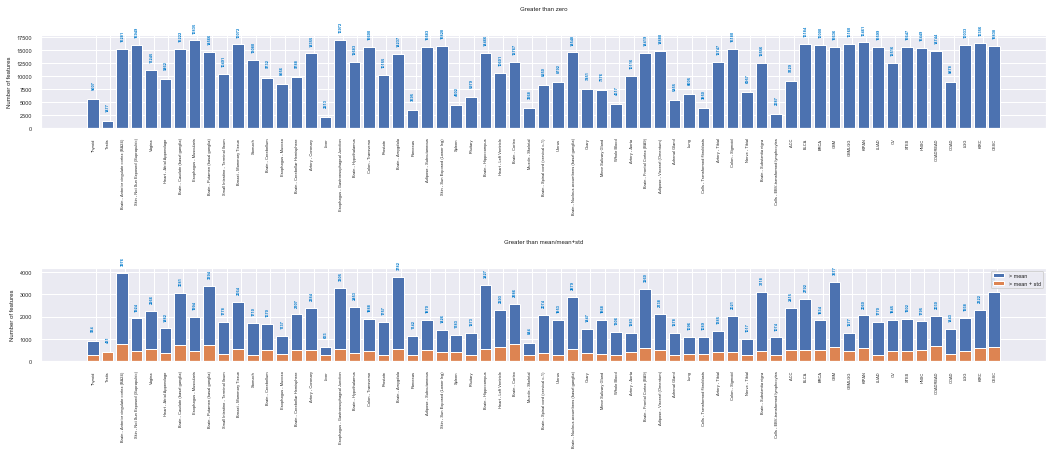

In [18]:
y1, y2, y3 = calc_features_statistics(feat)
show_bar_plots(y1, y2, y3, (3000, 600), 'bar1.png')

## Permutation importances

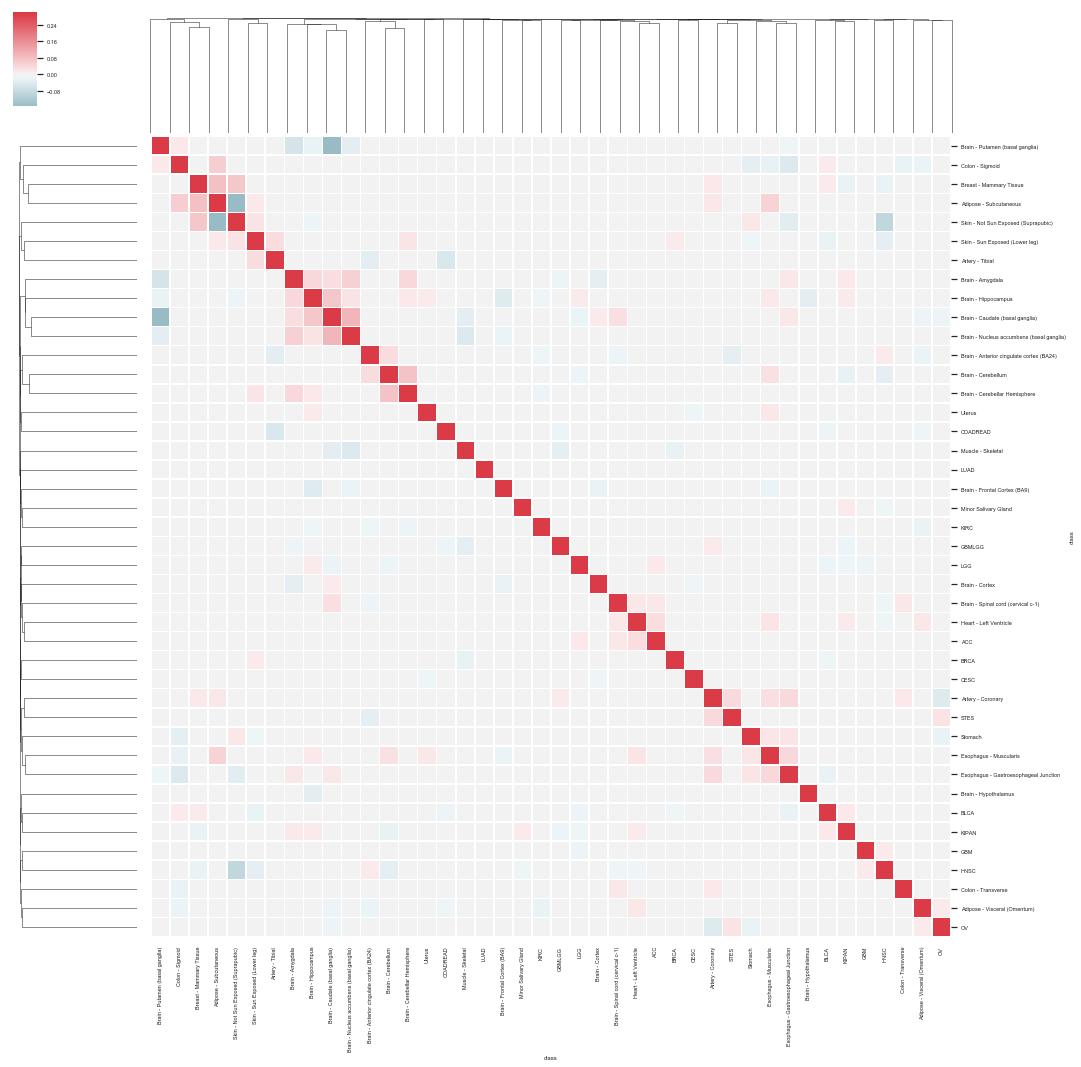

In [9]:
feat = reduce(pd.read_csv('files/features_meta_raw2.csv'))
feat = feat[(feat.T != 0).any()]
corr = feat.T.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(font_scale=0.5)
heatmap = sns.clustermap(corr, cmap=cmap, vmax=.3, center=0, square=True,
                         linewidths=.5, cbar_kws={"shrink": .5},
                         xticklabels=True, yticklabels=True, figsize=(17, 17))
plt.savefig('heatmap2.png', dpi=170)
plt.tight_layout()

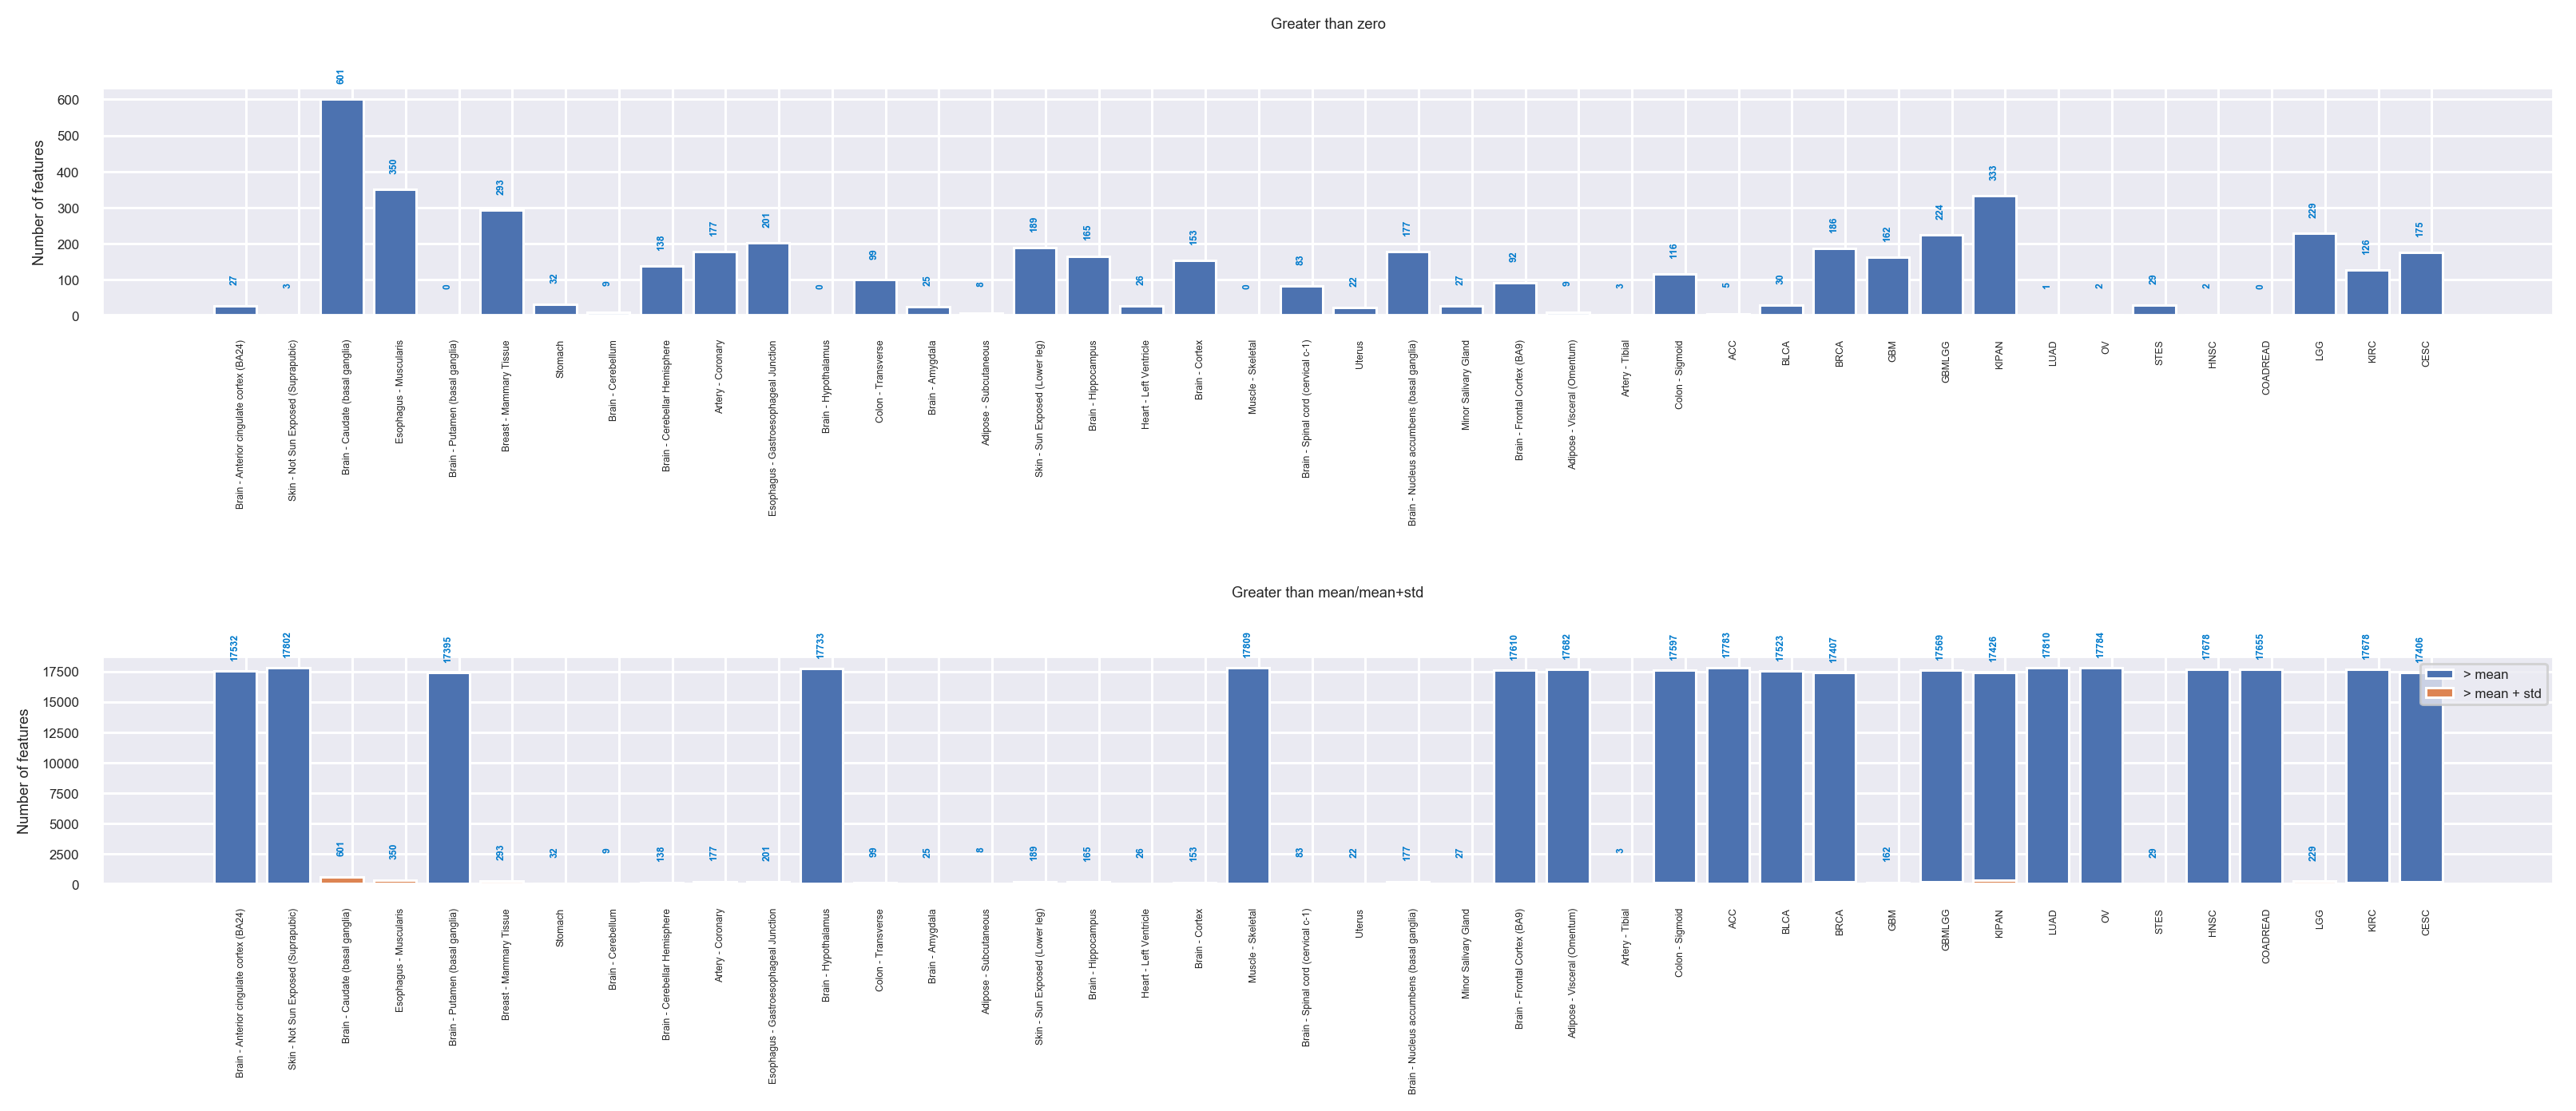

In [328]:
y1, y2, y3 = calc_features_statistics(feat)
show_bar_plots(y1, y2, y3, (70, 2500), 'bar2.png')

# Top 1000 genes for gorilla

In [ ]:
order = np.argsort(-df.values, axis=1)[:, :1000]

In [ ]:
rank = pd.DataFrame(df.columns[order], index=df.index)

In [ ]:
for cls in df.index:
    genes = rank.loc[cls].values
    with open('gorilla/{}.txt'.format(cls), 'w+') as f:
        for g in genes:
            f.write('{}\n'.format(g))

## Model validation

In [3]:
x_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
pred = clf.predict(x_test)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

In [36]:
report = classification_report(y_pred=pred, y_true=y_test, target_names=feat.index)
print(report)

                                           precision    recall  f1-score   support

                                  Thyroid       1.00      1.00      1.00       133
                                   Testis       1.00      1.00      1.00        83
 Brain - Anterior cingulate cortex (BA24)       0.85      0.85      0.85        41
      Skin - Not Sun Exposed (Suprapubic)       0.99      0.93      0.96       136
                                   Vagina       0.97      0.95      0.96        37
                 Heart - Atrial Appendage       1.00      0.98      0.99       105
          Brain - Caudate (basal ganglia)       0.82      0.85      0.83        53
                   Esophagus - Muscularis       0.72      0.85      0.78        99
          Brain - Putamen (basal ganglia)       0.84      0.86      0.85        43
         Small Intestine - Terminal Ileum       0.94      0.98      0.96        45
                  Breast - Mammary Tissue       0.99      0.90      0.94        90
   

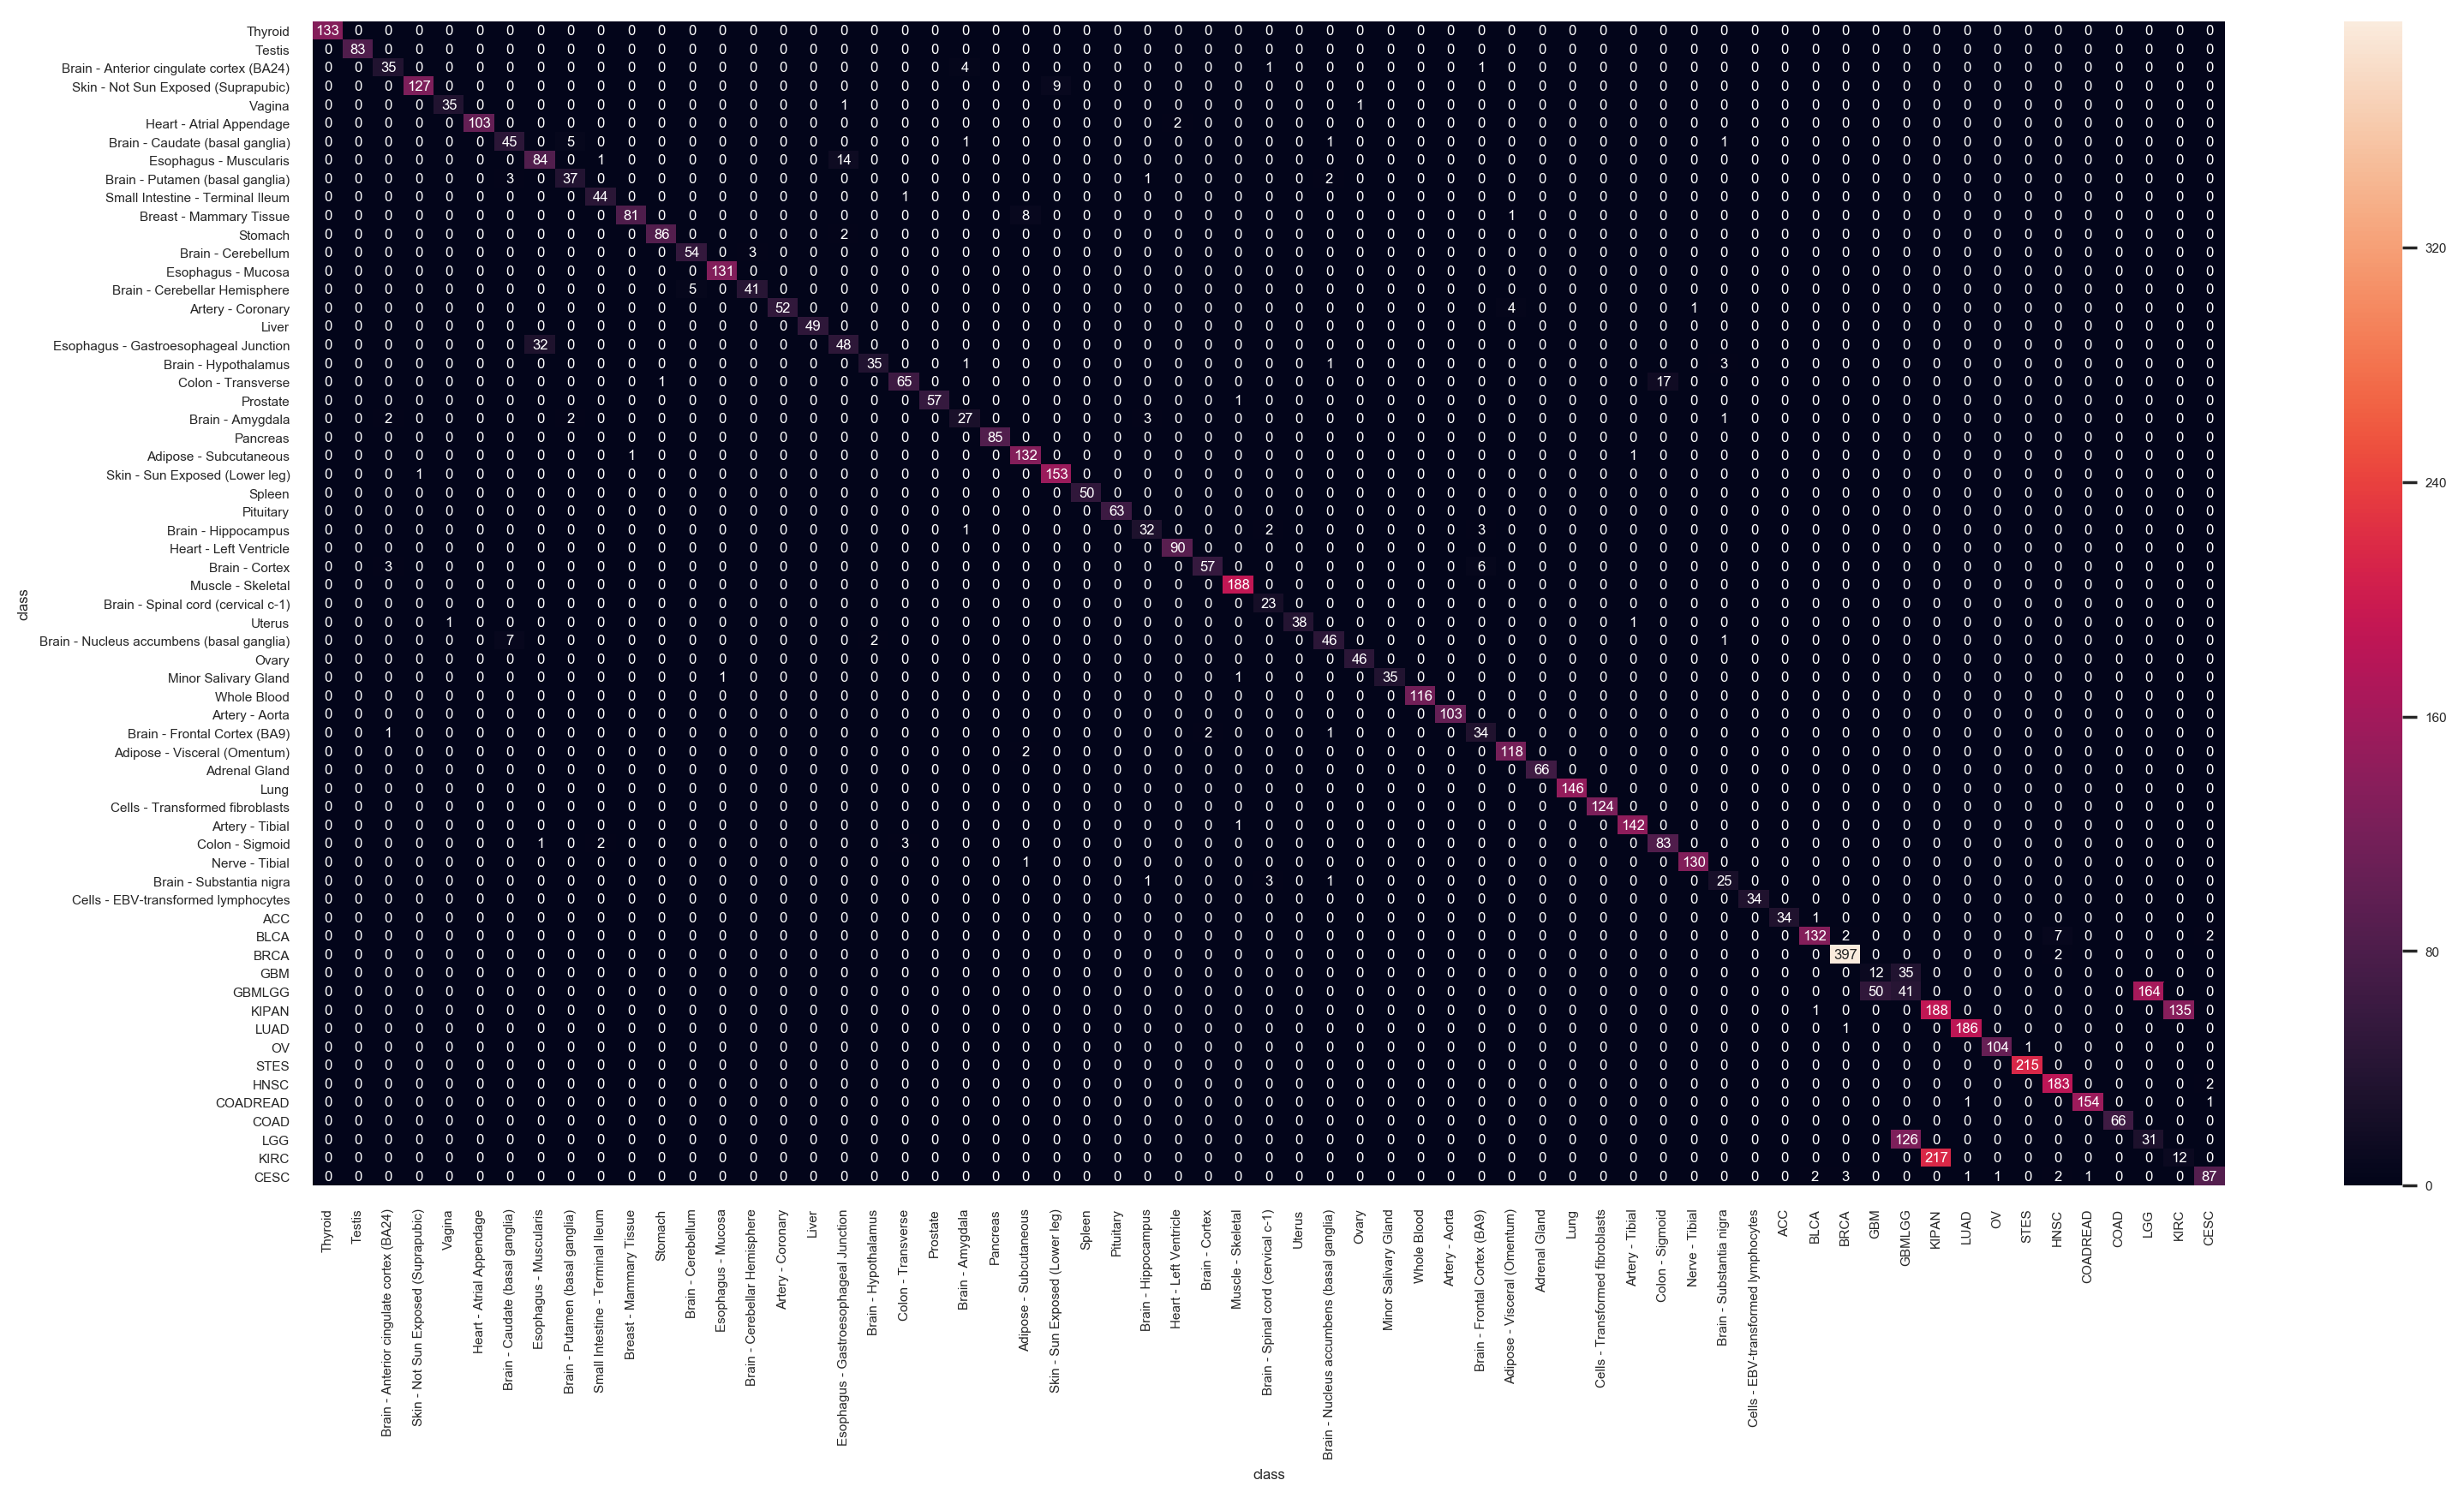

In [33]:
import seaborn as sn

mat = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(mat, feat.index, feat.index)
plt.figure(figsize=(18, 9), dpi=200)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('confusion_matrix.png', dpi=200)

In [35]:
balanced_accuracy_score(y_test, pred)

0.8875535065516185